# Energy Demand Forecasting with Granite Timeseries (TTM)

Based on the [Granite-Timeseries-TTM](https://github.com/ibm-granite/granite-tsfm/blob/cookbook-dev/notebooks/recipes/energy_demand_forecasting/demand_forecast_zeroshot_recipe.ipynb) notebook.

### Install the TSFM Library 
NOTE: For Python 3.12 and above, you will need to install `setuptools`, which provides `distutils`.

In [2]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git@cookbook-dev"

# Install setuptools to get distutils.
! pip install setuptools

  Cloning ssh://****@github.com/ibm-granite/granite-tsfm.git (to revision cookbook-dev) to /private/var/folders/nc/jrql4k0n2j73h7xktzxdr4pr0000gn/T/pip-install-yzw4iudk/tsfm-public_333b80d8a9fc4603b1a443406b861ec3
  Running command git clone --filter=blob:none --quiet 'ssh://****@github.com/ibm-granite/granite-tsfm.git' /private/var/folders/nc/jrql4k0n2j73h7xktzxdr4pr0000gn/T/pip-install-yzw4iudk/tsfm-public_333b80d8a9fc4603b1a443406b861ec3
  Running command git checkout -b cookbook-dev --track origin/cookbook-dev
  Switched to a new branch 'cookbook-dev'
  Branch 'cookbook-dev' set up to track remote branch 'cookbook-dev' from 'origin'.
  Resolved ssh://****@github.com/ibm-granite/granite-tsfm.git to commit 07eb7f217bdc4ef08894cbc67c9efe42a745732b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-2.2.2-cp312-cp312-macosx_10_9_x86_64.whl.metadata (19 kB)
  Using cached scikit_lear

### Import Packages

In [3]:
import tsfm_public
tsfm_public.__version__

'0.2.9.dev24+g07eb7f2'

In [40]:
import pandas as pd
import tempfile
import os

from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TimeSeriesForecastingPipeline,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

### Download the data

Download energy_data.csv.zip from Kaggle [here](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather), and set the path to the data file.


In [5]:
DATA_FILE_PATH = "~/Downloads/energy_dataset.csv.zip"

### Specify time and output variables


In [54]:
timestamp_column = "time"
target_columns = ["total load actual", "price actual"]

### Read in the Data

In [22]:
df_tmp = pd.read_csv(
  DATA_FILE_PATH
)

### Inspect the Data

In [34]:
df_tmp.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


### Plot the target Series

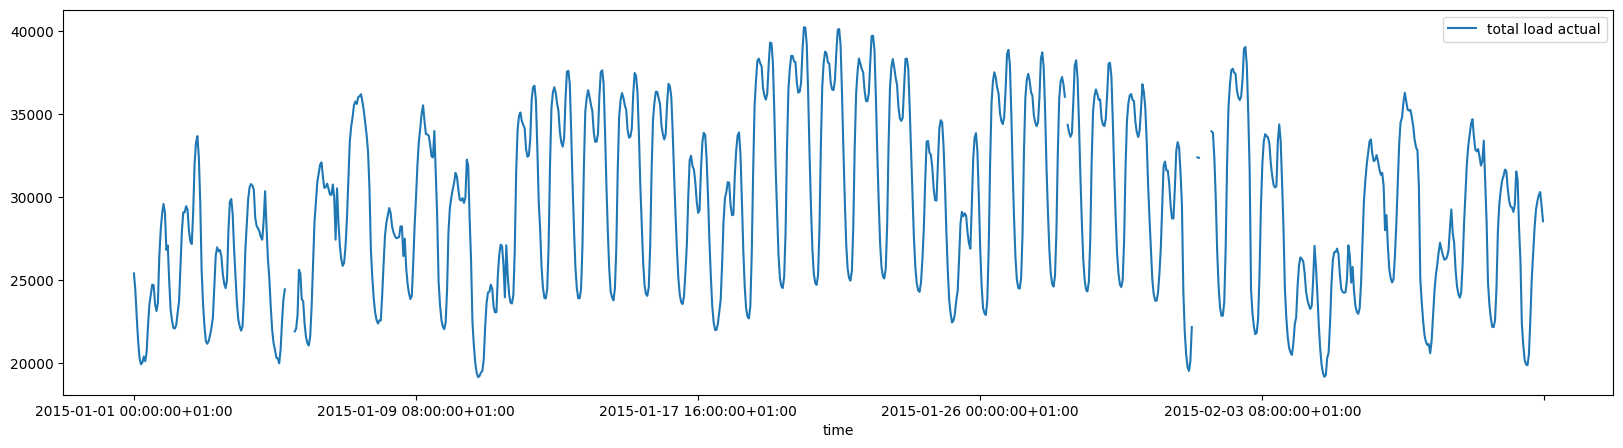

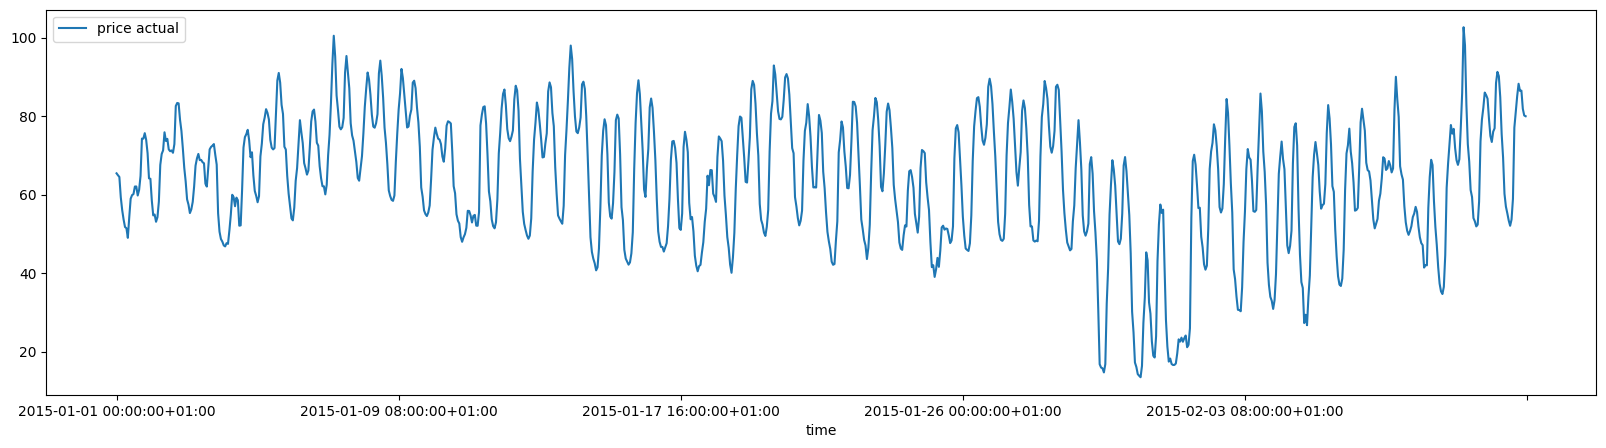

In [24]:
for target_column in target_columns:
  df_tmp.iloc[:1000].plot(x=timestamp_column, y=target_column, figsize=(20, 5))

### Get the test set for making predictions

In [13]:
# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

dataset_path = DATA_FILE_PATH
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24 * 4],
    "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
    "test": [
        12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
        12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

ValueError: Missing column provided to 'parse_dates': 'date'

## Prepare the Data

In [49]:
params = dict(
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    control_columns=[],
    context_length=512,
    prediction_length=96,
    freq="D",
)

tsp = TimeSeriesPreprocessor(
    **params,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

tsp = tsp.train(df_tmp)

prepared_dataset = tsp.preprocess(df_tmp)
prepared_dataset.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,-0.723934,50.10,0.529854
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,-0.943172,48.10,0.495356
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,-1.303397,47.33,0.464379
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,-1.619905,42.27,0.101098
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,-1.843297,38.41,-0.129825


### Set up zero shot model

In [36]:
# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
  "ibm-granite/granite-timeseries-ttm-v1", 
  revision=TTM_MODEL_REVISION,
  num_input_channels=tsp.num_input_channels,
  prediction_channel_indices=tsp.prediction_channel_indices,
)

model_parameters = sum(
  p.numel() for p in zeroshot_model.parameters() if p.requires_grad
)
print("TTM Model Parameters:", model_parameters)

TTM Model Parameters: 805280


### Create a forecasting pipeline and evaluate model performance.

Specify your local GPU device with the `device` parameter.

In [53]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=target_columns,
    control_columns=[],
    batch_size=2000,
    feature_extractor=tsp,
    device="mps",
)

zeroshot_forecast = pipeline(prepared_dataset, inverse_scale_outputs=True)
zeroshot_forecast.head()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

### Evaluate the model

In [46]:
zeroshot_trainer.evaluate(prepared_dataset)

KeyError: 0

### Make and plot predictions on the test set, along with the actuals

In [12]:
# plot
plot_predictions(
    model=zeroshot_model,
    dset=df_tmp,
    plot_dir=os.path.join(temp_dir, "plots"),
    plot_prefix="test_zeroshot",
    channel=0,
)

KeyError: 6070